In [82]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods

In [83]:
def plot_train_vs_test(train_scores, test_scores, points = {}, time = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")
    plt.show()

    maxarg = list(test_scores.keys())[np.argmax(list(test_scores.values()))]
    print("AT", maxarg, test_scores[maxarg], "WITH", len(points), "ITERATIONS IN", time, "SECONDS")

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [84]:
n_features = 200
X, y = make_classification(n_samples = 8000, n_features = n_features, n_informative = 30, random_state=8)
X_train, X_test = np.split(X, [1000])
y_train, y_test = np.split(y, [1000])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# SVM-RFE

In [85]:
@time_func
def SVM_RFE_NO_STEP():
    kf = KFold(n_splits=20, shuffle=True)

    index = [(test_index, train_index, 1) for test_index, train_index in kf.split(data.X_train)]
    with Pool(6) as pool:
        scores = pool.map(data.svm_rfe, index)

    #scores = list(map(data.svm_rfe, index))

    scores = list(scores)
    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, {}, time)

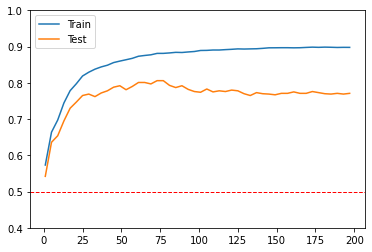

AT 73 0.806 WITH 0 ITERATIONS IN 4.057299017906189 SECONDS
__main__.SVM_RFE_NO_STEP - 00:00:20.738271500


In [86]:
SVM_RFE_NO_STEP()

# SVM-RFE with Step


In [87]:
@time_func
def SVM_RFE_W_STEP(step):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(test_index, train_index, step) for test_index, train_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe, index)

    # scores = list(map(data.svm_rfe, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])

    plot_train_vs_test(train_scores, test_scores, points, time)

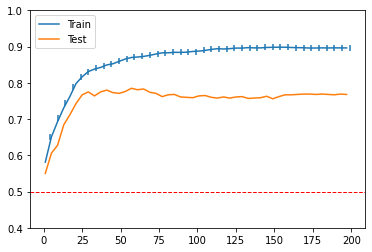

AT 57 0.7849999999999999 WITH 40 ITERATIONS IN 0.9788405060768127 SECONDS
__main__.SVM_RFE_W_STEP - 00:00:08.551272400


In [88]:
SVM_RFE_W_STEP(5)


# Display tradeoff

In [113]:
def plot_train_vs_test_t(train_scores, test_scores, spoint, wo, points = {}, time = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    plt.scatter(spoint[0], spoint[1], s=10, c='red')
    w = [-wo[1]/n_features, wo[0]]
    b = w[0]*spoint[0] + w[1]*spoint[1]
    xleft, xright = plt.xlim()
    xd = np.array([xleft, xright])
    yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
    plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS")

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

@time_func
def SVM_RFE_W_STEP_T(step, w1, w2, w3):
    kf = KFold(n_splits=20, shuffle=True)

    index = [(test_index, train_index, step) for test_index, train_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe, index)

    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])

    plot_train_vs_test_t(train_scores, test_scores, scal(test_scores, w1), w1, points, time)
    plot_train_vs_test_t(train_scores, test_scores, scal(test_scores, w2), w2, points, time)
    plot_train_vs_test_t(train_scores, test_scores, scal(test_scores, w3), w3, points, time)

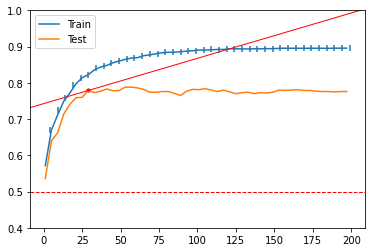

AT (29, 0.7790000000000001, 0.2057999999999999) WITH 40 ITERATIONS IN 0.9670381307601928 SECONDS


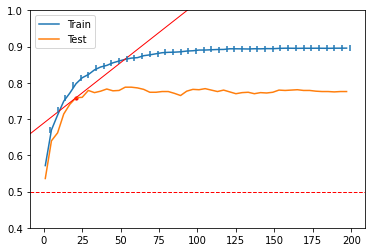

AT (21, 0.759, 0.1866) WITH 40 ITERATIONS IN 0.9670381307601928 SECONDS


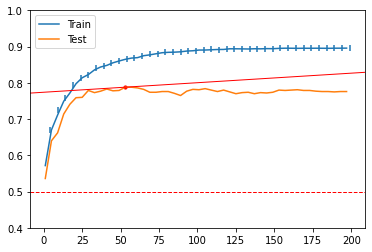

AT (53, 0.788, 0.21464999999999998) WITH 40 ITERATIONS IN 0.9670381307601928 SECONDS
__main__.SVM_RFE_W_STEP_T - 00:00:09.044444900


In [115]:
SVM_RFE_W_STEP_T(5, [0.8, 0.2], [0.6, 0.4], [0.95, 0.05])